# Quantum Phase Estimation on IBM hardware

Now that you should be properly registered with IBM and able to run programs on their quantum devices, it's time to compute something useful.

In this notebook we're going to do just that with the Quantum Phase Estimation algorithm, which we saw about three weeks ago. Since we stay in the Qiskit ecosystem, we'll be able to reuse a lot of code we've built before.

As you've seen last week, quantum computers usually suffer from noise. Here we'll be able to compare that directly with our noiseless experience in the original quantum phase estimation notebook.

To motivate you perhaps a bit more, note that such hardware runs are actually quite hard. For example, a somewhat recent preprint ran Shor's algorithm -- whose crucial component is QPE -- on 10 qubits. So in this notebook we're not necessarily going for state-of-the-art results, but still something very much non-trivial.

If you follow this notebook to the end, you'll be able to get **the bonus** which counts for one blackboard presentation (meaning you still need to do one presentation to get the full bonus, but not two)

Before we start anything, the first step to get **the bonus** is to write your name and idm number in this cell and run it:

In [22]:
your_name = "Dustin Seboldt"
your_idm = "uv67ewyk"


OK let's `pip install`

In [23]:
#%pip install qiskit[visualization] --quiet
#%pip install qiskit_ibm_runtime --quiet
#%pip install matplotlib --quiet
#%pip install qiskit-aer --quiet

As stated before, let's reuse all our QPE code. This time, we'll be trying to solve a more interesting model than simply a random unitary $U$: we'll be studying some Hamiltonian, as we did in the parametrized gate notebook. Since we want to make this an actually interesting result, but we will have to deal with noise, we'll go with a very simple Ising model, simpler than the one we saw back then:

$$ H = J \sum_i Z_i Z_{i+1} $$

and we'll pick the ground state of the model, that is $|E_0\rangle=|1010...0101\rangle$. It can also be $|010101...10\rangle$ Generally, notice that since $ZZ|10\rangle = -|10\rangle$, and $ZZ|01\rangle = -|01\rangle$ but $ZZ|11\rangle = |11\rangle$ and $ZZ|00\rangle = |00\rangle$ the ground states are easy to find. We'll try to guess its phase using the IBM quantum device. The phase in question will actually be the eigenenergy of the ground state, since

$$ e^{iHt}|E_0\rangle=\sum_k \frac{(it)^k H^k}{k!}|E_0\rangle=\sum_k \frac{(it)^k E_0^k}{k!}|E_0\rangle=e^{iE_0 t}|E_0\rangle$$

Notice that we need to be careful, since there might exist $E_j=E_0 + 2\pi n$, and we can't distinguish them (because the exponential is periodic.) This means we need to pick a $t$ which is ensures the differnet eigenvalues don't overlap.

Below are a lot of new utility functions, adapted from the previous notebooks. We'll use them to move from bitstring to index, from energy to phase and so on. They are not conceptually critical, but necessary to run the functions correctly.

In [24]:
from typing import Iterable, Union

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.result import Counts
from qiskit.visualization import plot_histogram


def from_bitstring(n_qubits: int, bitstring: str) -> int:
    if isinstance(bitstring, str):
        ind = np.sum([2 ** (n_qubits - 1 - int(b)) for b in bitstring])
        return ind
    else:
        return bitstring


def to_bitstring(n_qubits: int, ind: str) -> int:
    return format(ind, "0{lp}b".format(lp=n_qubits))


def time_evolution_unitaries(r1: int, ham: np.ndarray, time: float) -> Iterable:
    for m in range(r1):
        rut = PauliEvolutionGate(ham, time=-time * (2**m))
        yield rut


def controlled_U_gate(
    circ: QuantumCircuit, ctrl: int, targs: list, pauli_evgate: PauliEvolutionGate
) -> None:
    pauli_cevgate = pauli_evgate.control(1)
    circ.append(pauli_cevgate, qargs=[ctrl, *targs])


def get_targets(hamiltonian: np.ndarray, idx: int) -> Union[float, np.ndarray, str]:
    eigvals, eigvecs = np.linalg.eigh(hamiltonian)
    if idx == -1:
        idx = len(eigvals) - 1
    target_energy = eigvals[idx]
    n_qubits = int(np.log2(len(eigvals)))
    target_state = eigvecs[:, idx]

    target_state_bitstring = to_bitstring(n_qubits, int(np.argmax(target_state)))
    return target_energy, target_state, target_state_bitstring


def phase_from_counts(counts: dict) -> float:
    counts = Counts(counts)
    bitstring = counts.most_frequent()
    fig = plot_histogram(counts)
    return (
        np.sum([(int(v)) * 2 ** -(i + 1) for i, v in enumerate(bitstring)]),
        bitstring,
        fig,
    )


def phase_from_statevector_simulation(
    circ: QuantumCircuit, n_shots: int = 1000
) -> Union[float, dict]:
    statevector = Statevector.from_instruction(circ)
    r1 = len(circ.qregs[0])
    counts = statevector.sample_counts(n_shots, qargs=range(r1))
    return *phase_from_counts(counts), counts


def print_info(
    target_phase: float,
    computed_phase: float,
    output_bitstring: str,
    correct_bitstring: str,
) -> None:
    print(
        f"correct bitstring: {correct_bitstring} most frequent bitstring: {output_bitstring}"
    )
    print(
        f"correct phase: {target_phase:.5f}, guessed phase: {computed_phase:.5f} err: {np.abs(target_phase-computed_phase):.5f}"
    )


def get_correct_bitstring(target_phase: float, r1: int) -> str:
    return to_bitstring(r1, int(np.round(target_phase * (2**r1))))


def bitstring_preparation_circuit(circ: QuantumCircuit, bitstring: str) -> None:
    x_gate_list = [
        circ.qregs[1][ind]
        for ind in range(len(bitstring))
        if bitstring[::-1][ind] == "1"
    ]
    if x_gate_list != []:
        circ.x(x_gate_list)

Okay, now we write again the QPE circuit, slightly modified: we now take a Hamiltonian $H$ as argument, as well as a `time_scaling`, which allows us to change overall scaling of the time evolution.

Of course, creating the circuit is your task. Write your code in the cell below:

In [25]:
def qpe_circuit(r1: int, ham: SparsePauliOp, target_idx: int, time_scaling: float):

    r2 = ham.num_qubits
    target_energy, target_state, target_state_bitstring = get_targets(
        ham.to_matrix(), target_idx
    )
    target_phase = np.mod(target_energy * time_scaling / (2 * np.pi), 1)

    first_register = QuantumRegister(r1, "first")
    second_register = QuantumRegister(r2, "second")


    circ = QuantumCircuit(first_register, second_register)
    time_unitaries = time_evolution_unitaries(r1, ham, time=time_scaling)

    # CREATE the QPE circuit!
    # hint: you have the controlled-U at your disposition above,
    # and the bitstring_preparation_circuit function to prepare (in the second register)
    # the state whose phase we estimate
    # you can use the QFT from qiskit directly
    # generally notebook 4 should be useful

    circ.h(first_register)

    bitstring_preparation_circuit(circ=circ, bitstring=target_state_bitstring)

    for j in time_unitaries:
        controlled_U_gate(circ=circ, ctrl=j, targs=second_register, pauli_evgate=j)             #ERROR HERE!!!!!!!!!!! replace j with 0-4 works, >5 error (makes sense) but also with j while j only goes from 0-4, but still gives this error
        print(j)    #so you can see that j in fact produces 5 elements --> j = 0,1,2,3,4
        
    circ.append(QFT(num_qubits=len(first_register),inverse=True,do_swaps=True),qargs=first_register)
    


    return circ, target_phase, target_state, target_state_bitstring

Let's create the Hamiltonian we described in the beginning. It's the same as in notebook 3, but with the $X$ part out. If you feel you can take a stab at it, feel free to put it back in (you will need to generate the appropriate state though).

Pick the number of qubits in the first and second registers, `r1` and `r2`: this will decide how big the simulation is, so don't go overboard.

Write the Hamiltonian and the qubit numbers in the cell below:

In [26]:
r1= 5
r2= 5

# Write the Hamiltonian!
J = 1

hamiltonian:SparsePauliOp = sum(J*[SparsePauliOp(s*"I"+"ZZ"+(r2-2-s)*"I") for s in range(r2-1)])


Now that we've got the Hamiltonian, let's call the QPE circuit, and test whether it works in an ideal setting.

In [27]:
time_scaling = 1
target_idx = 0

circ, target_phase, target_state, target_state_bitstring = qpe_circuit(
    r1, hamiltonian, target_idx, time_scaling
)
correct_bitstring = get_correct_bitstring(target_phase, r1)
sv_computed_phase, sv_output_bitstring, sv_fig, sv_counts = (
    phase_from_statevector_simulation(circ)
)


print(
    f"QPE circuit has: Hamiltonian with {r2} qubits, phase estimation register with {r1} qubits."
)
print(
    f"The phase resolution is {2**(-r1)}: error should be smaller than this value."
)
print_info(target_phase, sv_computed_phase, sv_output_bitstring, correct_bitstring)
sv_fig.suptitle("Statevector simulation")
# neat trick to show the figure in jupyter notebook
sv_fig

CircuitError: "Invalid bit index: 'Instruction(name='PauliEvolution', num_qubits=5, num_clbits=0, params=[-1.0])' of type '<class 'qiskit.circuit.library.pauli_evolution.PauliEvolutionGate'>'"

Okay, the results should hopefully be correct, the QPE algorithm finding something close enough to the correct value.

Now, we need to create the link between our QPE circuit and the hardware. We can modify last week's notebook to fit that purpose. Since we only need to measure a single bitstring in the end, we will simply measure the bitstrings from the first register and see which one (hopefully the right one) is the most frequent. So we'll won't require any observables. We must, however, add a classical register to our circuit, to be able to sample it in an experimental setting.

In [ ]:
measurement_register = ClassicalRegister(r1, "meas")
circ.add_register(measurement_register)
circ.measure(circ.qregs[0], measurement_register)

Let's see how that circuit looks now.

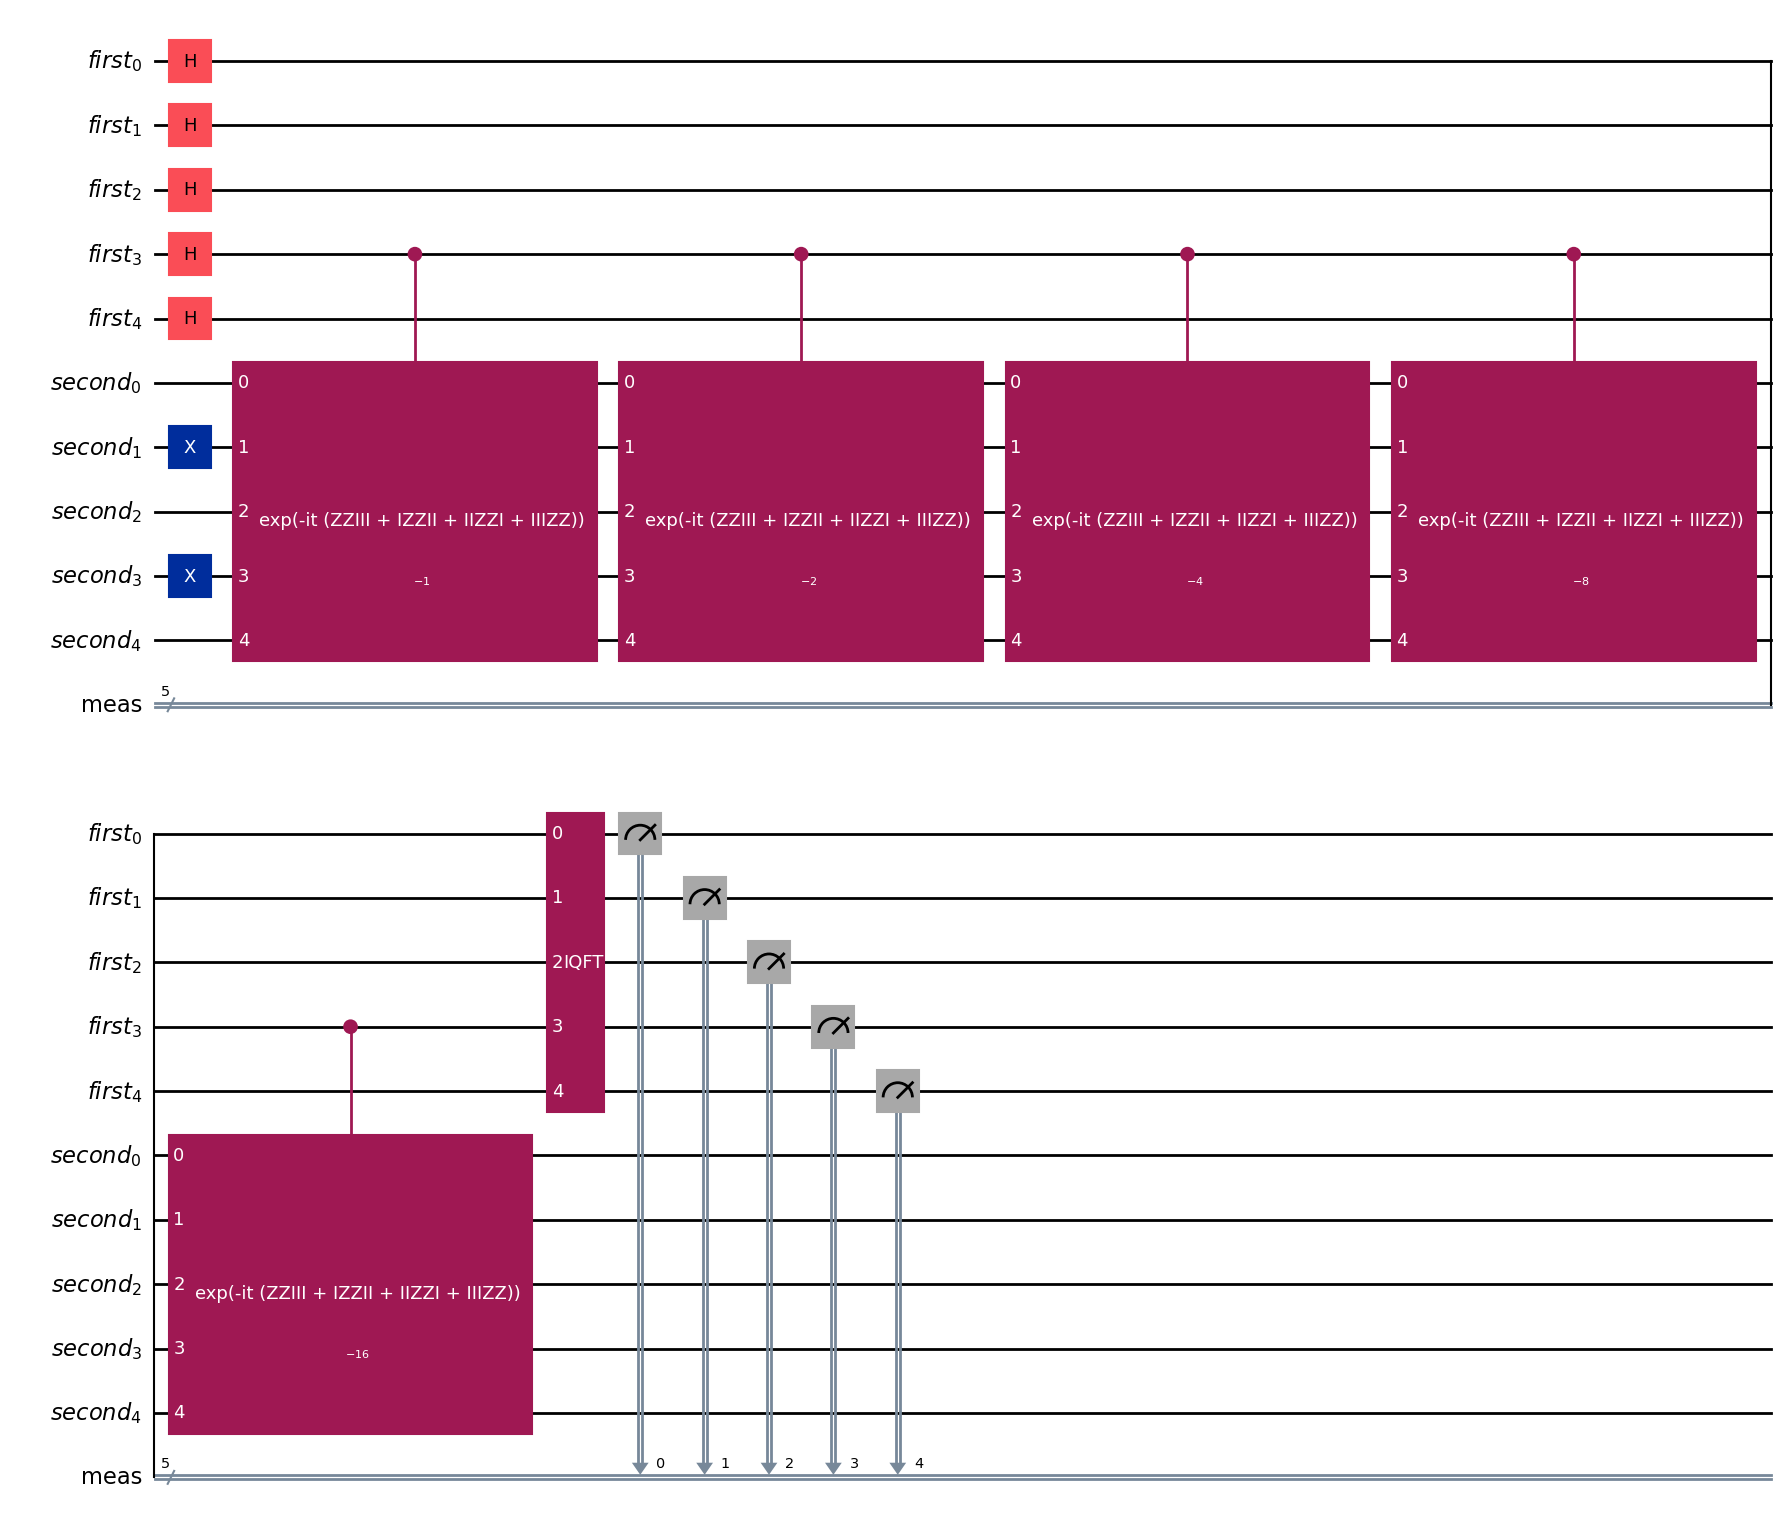

In [ ]:
circ_fig=circ.draw("mpl")
circ_fig

(it should look like a QPE circuit)

Now we need to connect to IBM to access the fake simulators. Again, you have to replace the `token = ...` part with your own access token.

In [ ]:
import io
from qiskit_ibm_runtime import QiskitRuntimeService

token = ...
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got 'Ellipsis'."

Again, we make use of a _fake backend_ to pre-screen our results. Pick a fake backend from the IBM fake backend list, import it, and run the simulation. This doesn't cost any of your free IBM minutes.

Note that we could also simulate a fake version of the real backend we want to use, by calling `AerSimulator.from_backend(real_backend)`, but we don't want to complicate things too much.

Below, fill out the ellipsed parts (`...`):

In [ ]:
from qiskit_ibm_runtime.fake_provider import ...
from qiskit_ibm_runtime import SamplerV2, RuntimeJob
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator


def backend_sample(backend, circuit: QuantumCircuit, n_shots: int)->RuntimeJob:
    estimator = SamplerV2(backend=backend)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)
    job = estimator.run([(isa_circuit,)], shots=n_shots)
    return job


def get_counts_from_job(job: RuntimeJob)->dict:
    return job.result()[0].data.meas.get_counts()


n_shots = ...
fake_backend = ...
# make sure we use the noisy simulator (use this one in the simulation)
backend_sim = AerSimulator.from_backend(fake_backend)

# sample the circuit with the desired backend
fake_job_result = ...
fake_counts = ...

# print and plot results
fake_computed_phase, fake_output_bitstring, fake_fig = phase_from_counts(fake_counts)
print_info(target_phase, fake_computed_phase, fake_output_bitstring, correct_bitstring)
fake_fig.suptitle(f"Fake run on {fake_backend.name}")
fake_fig

Alright, the results should be quite worse than before, still the correct bitstring should peak above the others, such that we are again able to estimate the phase.

Now, we run the job on the Qiskit platform. You can see the progress on the [jobs page](https://quantum.ibm.com/jobs).

We connect to a real quantum device backend as in the last notebook. Then we can finally run QPE on a real quantum computer! (how exciting)

Here you have to:

- Pick a number of shots. Between 100 and 1000 is a good choice, but you can also go higher (which will cost you more time).
- Run the sampler with the correct backend, and get the counts
- Set `which` to `run`, and you're good to go.
- Replace all the ellipsis, generally speaking.

Again, you can reload a job with `which="load"` and the job key (as explained in the previous notebook.)


In [ ]:
real_backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=r1 + r2
)

n_shots = ...
which = ...

if which == "run":
    real_job = ...
elif which == "load":
    job_key = ...
    real_job = service.job(job_key)
else:
    raise ValueError(f"Expected 'run' or 'load', got: {which}")

real_counts = ...
real_computed_phase, real_output_bitstring, real_fig = phase_from_counts(real_counts)
print_info(target_phase, real_computed_phase, real_output_bitstring, correct_bitstring)
real_fig.suptitle(f"Hardware run on {real_job._backend.name}")
real_fig

**SPOILER ALERT** your results might not be very good because of noise. If you've gotten correct results in the first part of the exercise, and the hardware results are not, then it is very likely that the quantum device is very noisy, and the circuit's output is dominated by noise rather than by the signal

## Get the bonus & wrap up

Now if you want to get **the bonus**, you only need a couple more steps. Make sure your name and IDM are correct in the first cell, and run the cell below. It should generate a zip file in the current folder. Send this zip file to `lucas.marti@fau.de` and you will get the bonus. It's that simple. If you're on Google colab, there's a folder icon in the left-hand sidebar. The zip file should be there.

If you want to get even more bonus (and the most satisfying bonus of all: knowledge), feel free to tinker with the notebook.

We only went for a minimal version of QPE, but we're already quite advanced in terms of application, on the threshold of research one might say. If you were disappointed by the noisy results, you can look into error mitigation and post-selection. If you feel the Hamiltonian is too basic, you can add terms (but you need to know how to create the state). If you think we didn't have enough qubits in the experiment, know that the IBM hardware can go up to about a hundred qubits: you can scale up, but you won't be able to run a fake simulation to ensure the correctness of your results. There are also many ways to improve the algorithm itself, so that it runs in a shorter time. The sky's the limit.

In [ ]:
import zipfile
import json
from datetime import datetime


def fig_to_zip(fig, fn, zf):
    fig_opts = {"format": "pdf", "bbox_inches": "tight", "pad_inches": 0.01}
    buf = io.BytesIO()
    fig.savefig(buf, **fig_opts)
    zf.writestr(fn, buf.getvalue())


def np_dict_to_dict(d):
    return {k: int(v) for k, v in d.items()}


job = real_job.__repr__()
ham = str(hamiltonian)
jobj = {
    "__timestamp": datetime.today().strftime("%d/%m/%Y at %H:%M %Ss"),
    "__jobj": job,
    "__ham": ham,
    "__name": your_name,
    "__idm": your_idm,
    "__fake_backend": fake_backend.name,
    "__real_backend": real_backend.name,
    "__sv_counts": np_dict_to_dict(sv_counts),
    "__fake_counts": np_dict_to_dict(fake_counts),
    "__real_counts": np_dict_to_dict(real_counts),
    "__target_phase": target_phase,
    "__correct_bitstring": correct_bitstring,
    "__sv_computed_phase": sv_computed_phase,
    "__sv_output_bitstring": sv_output_bitstring,
    "__fake_computed_phase": fake_computed_phase,
    "__fake_output_bitstring": fake_output_bitstring,
    "__real_computed_phase": real_computed_phase,
    "__real_output_bitstring": real_output_bitstring,
}

zf_fpath = f"./{your_name.replace(' ','_')}_{your_idm}.zip"

with zipfile.ZipFile(zf_fpath, mode="w") as zf:
    fig_to_zip(sv_fig, "stevector_results.pdf", zf)
    fig_to_zip(fake_fig, "fake_results.pdf", zf)
    fig_to_zip(real_fig, "real_results.pdf", zf)
    fig_to_zip(circ_fig, "circuit.pdf", zf)

    buf = io.BytesIO()
    data = json.dumps(jobj, indent=4, ensure_ascii=False).encode()
    buf.write(data)
    zf.writestr("specs.json", buf.getvalue())

print(f"Created {zf_fpath}")
print("Thank you for following along this Qiskit tutorial!")